In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 14.4 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=506a255a81edfc2b0b7fc64e23ae3726a7b1c18b811fc8c9bc3a2e34862a1c1b
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
Note: you may need to restart the kernel to use updated packages.


> **In this Notebook, I try to get all information that can be taken as useful insight from this data**

In [1]:
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *

In [2]:
import matplotlib.pyplot as plt
import seaborn as sb

In [3]:
spark = SparkSession.builder.master("local").appName("RealTime supermarket Sales").getOrCreate()

In [4]:
spark

# Exploration & Preprocessing

In [5]:
data = spark.read.csv("./supermarket_sales - Sheet1.csv" ,
                      header = True  , inferSchema=True)

In [6]:
data.show(5)

+-----------+------+---------+-------------+------+--------------------+----------+--------+-------+--------+---------+-------------------+-----------+------+-----------------------+------------+------+
| Invoice ID|Branch|     City|Customer type|Gender|        Product line|Unit price|Quantity| Tax 5%|   Total|     Date|               Time|    Payment|  cogs|gross margin percentage|gross income|Rating|
+-----------+------+---------+-------------+------+--------------------+----------+--------+-------+--------+---------+-------------------+-----------+------+-----------------------+------------+------+
|750-67-8428|     A|   Yangon|       Member|Female|   Health and beauty|     74.69|       7|26.1415|548.9715| 1/5/2019|2022-10-08 13:08:00|    Ewallet|522.83|            4.761904762|     26.1415|   9.1|
|226-31-3081|     C|Naypyitaw|       Normal|Female|Electronic access...|     15.28|       5|   3.82|   80.22| 3/8/2019|2022-10-08 10:29:00|       Cash|  76.4|            4.761904762|      

In [7]:
data.columns

['Invoice ID',
 'Branch',
 'City',
 'Customer type',
 'Gender',
 'Product line',
 'Unit price',
 'Quantity',
 'Tax 5%',
 'Total',
 'Date',
 'Time',
 'Payment',
 'cogs',
 'gross margin percentage',
 'gross income',
 'Rating']

In [8]:
types = data.dtypes
types

[('Invoice ID', 'string'),
 ('Branch', 'string'),
 ('City', 'string'),
 ('Customer type', 'string'),
 ('Gender', 'string'),
 ('Product line', 'string'),
 ('Unit price', 'double'),
 ('Quantity', 'int'),
 ('Tax 5%', 'double'),
 ('Total', 'double'),
 ('Date', 'string'),
 ('Time', 'timestamp'),
 ('Payment', 'string'),
 ('cogs', 'double'),
 ('gross margin percentage', 'double'),
 ('gross income', 'double'),
 ('Rating', 'double')]

In [9]:
data.printSchema()

root
 |-- Invoice ID: string (nullable = true)
 |-- Branch: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Customer type: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Product line: string (nullable = true)
 |-- Unit price: double (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Tax 5%: double (nullable = true)
 |-- Total: double (nullable = true)
 |-- Date: string (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Payment: string (nullable = true)
 |-- cogs: double (nullable = true)
 |-- gross margin percentage: double (nullable = true)
 |-- gross income: double (nullable = true)
 |-- Rating: double (nullable = true)



In [10]:
data.toPandas().describe

<bound method NDFrame.describe of       Invoice ID Branch       City Customer type  Gender  \
0    750-67-8428      A     Yangon        Member  Female   
1    226-31-3081      C  Naypyitaw        Normal  Female   
2    631-41-3108      A     Yangon        Normal    Male   
3    123-19-1176      A     Yangon        Member    Male   
4    373-73-7910      A     Yangon        Normal    Male   
..           ...    ...        ...           ...     ...   
995  233-67-5758      C  Naypyitaw        Normal    Male   
996  303-96-2227      B   Mandalay        Normal  Female   
997  727-02-1313      A     Yangon        Member    Male   
998  347-56-2442      A     Yangon        Normal    Male   
999  849-09-3807      A     Yangon        Member  Female   

               Product line  Unit price  Quantity   Tax 5%      Total  \
0         Health and beauty       74.69         7  26.1415   548.9715   
1    Electronic accessories       15.28         5   3.8200    80.2200   
2        Home and lifestyl

In [11]:
cat_columns = []
num_columns = []

for field in data.schema.fields:
    if str(field.dataType) == 'StringType()':
        cat_columns.append(field.name)
    else:
        num_columns.append(field.name)

In [12]:
split_date = split(data['Date'], '/')
data = data.withColumn('year',
                    split_date.getItem(2)).withColumn('month',
                                                     split_date.getItem(0)).withColumn('day',
                                                                                      split_date.getItem(1))

In [14]:
data

DataFrame[Invoice ID: string, Branch: string, City: string, Customer type: string, Gender: string, Product line: string, Unit price: double, Quantity: int, Tax 5%: double, Total: double, Date: string, Time: timestamp, Payment: string, cogs: double, gross margin percentage: double, gross income: double, Rating: double, year: string, month: string, day: string]

In [15]:
cat_columns.remove("Date")
cat_columns.remove("Invoice ID")
num_columns.remove("Quantity")
num_columns.remove('Time')
cat_columns.append("Quantity")

# Univariate Analysis

In [16]:
# make a univariate analysis for category columns
def univariate_cat(cat_columns , top = 10):
    for i in cat_columns:
        unique = data.groupby(i).count().sort("count" , ascending = False).toPandas()[:top]
        sb.barplot(data = unique , x = i , y = 'count')
        plt.title("number of {}'s appear in data ".format(i))
        plt.xticks(rotation = 90);
        minimum = unique['count'].min() - (unique['count'].max() - unique['count'].min())
        maximum = unique['count'].max() + (unique['count'].max() - unique['count'].min())
        plt.ylim(minimum , maximum);
        yield;

        

In [17]:
def univariate_num(num_columns):
    d = data.toPandas()
    for i in num_columns:
        sb.boxplot(data = d , x = i)
        yield

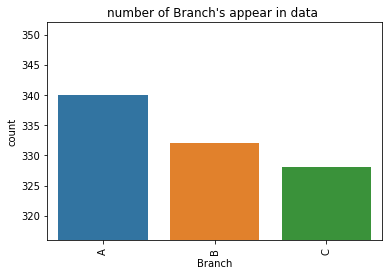

In [18]:
univariate = univariate_cat(cat_columns)
next(univariate)

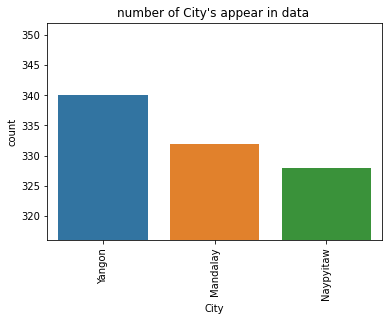

In [19]:
next(univariate)

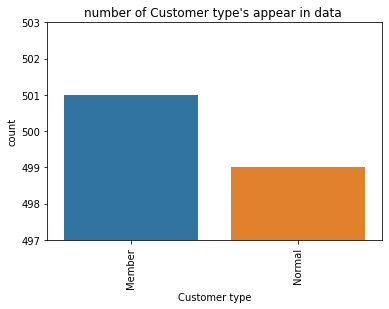

In [20]:
next(univariate)

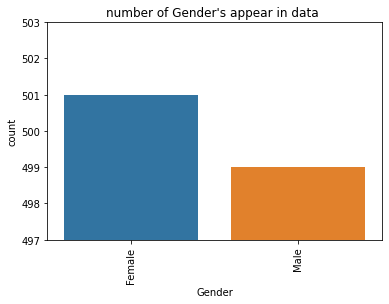

In [21]:
next(univariate)

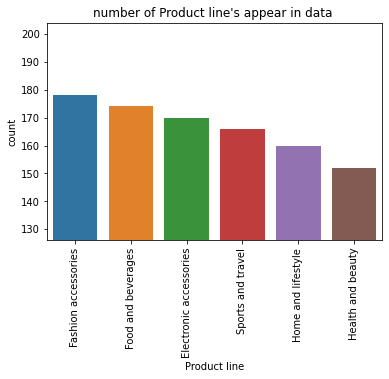

In [22]:
next(univariate)

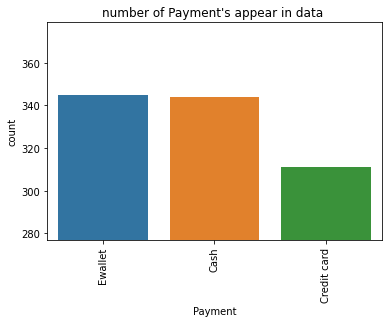

In [23]:
next(univariate)

##### see the 8 top day and month thatappear in our data (the top sales transactions happen in 2019)

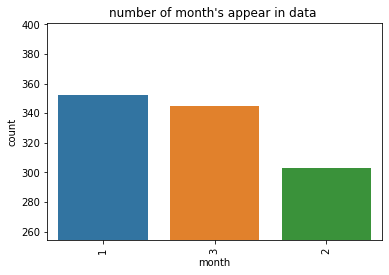

In [24]:
univariate_date = univariate_cat(['month' , 'day'] , 8)
next(univariate_date)

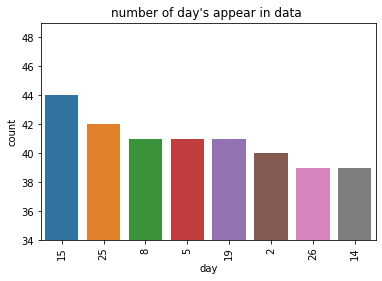

In [24]:
next(univariate_date)

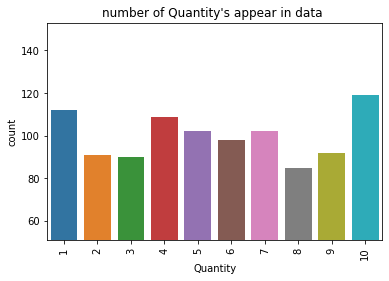

In [25]:
univariate_date = univariate_cat(['Quantity'])
next(univariate_date)

In [26]:
num_columns

['Unit price',
 'Tax 5%',
 'Total',
 'cogs',
 'gross margin percentage',
 'gross income',
 'Rating']

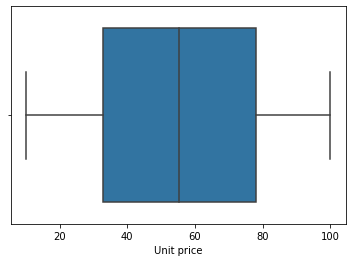

In [27]:
univariate_num = univariate_num(num_columns)
next(univariate_num)

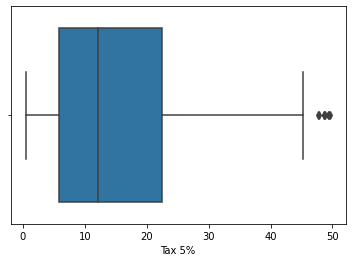

In [28]:
next(univariate_num)

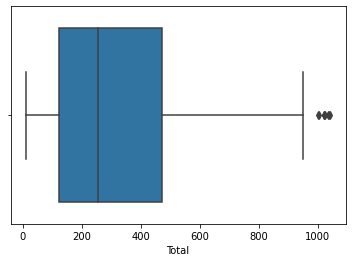

In [29]:
next(univariate_num)

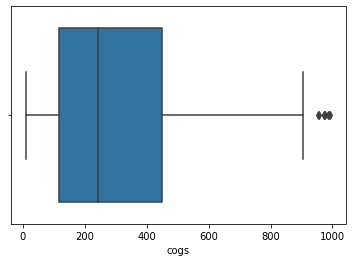

In [30]:
next(univariate_num)

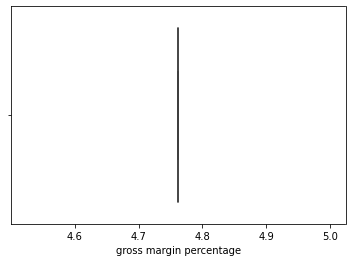

In [31]:
next(univariate_num)

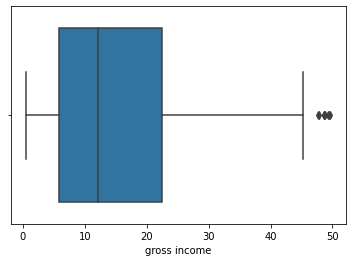

In [32]:
next(univariate_num)

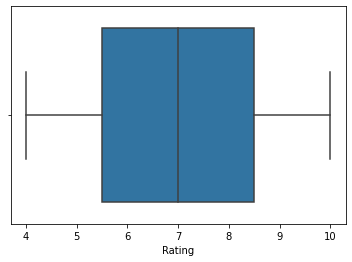

In [33]:
next(univariate_num)

# Bivariate Analysis

In [34]:
def bivariate_cat(cat_columns):
    for i in range(len(cat_columns)):
        for j in range(i+1 , len(cat_columns)):
                if i == j:
                    break
                x = cat_columns[i]
                hue = cat_columns[j]
                fig , ax = plt.subplots(2)
                fig.set_figheight(8)
                fig.set_figwidth(5)
#                 fig.title
                bivariate_data = data.groupby([x , hue]).count().sort(hue).toPandas()
#                 plt.subplot(1,2,1)
                sb.barplot(data = bivariate_data , x = x , y = 'count' , hue = hue  , ax = ax[0])
                plt.xticks(rotation = 90)
#                 plt.subplot(1,2,2)
                sb.barplot(data = bivariate_data , x = hue , y = 'count' , hue = x  , ax = ax[1])
                plt.xticks(rotation = 90)
                yield

In [35]:
# def bivariate_cat_num():
#     for i in cat_columns:
#         for j in num_columns:
#             d = data.select([i,j]).toPandas()
#             sb.boxplot(data = d  , x = i , y = j)
#             plt.xtixks(rotation = 90)
#             yield

In [35]:
def bivariate_cat_num(col1 , col2):
    res = data.groupby([col1]).sum(col2).toPandas()
    res.columns = [col1 , col2]
    sb.barplot(data = res , x = col1 , y = col2);
    plt.xticks(rotation = 90);

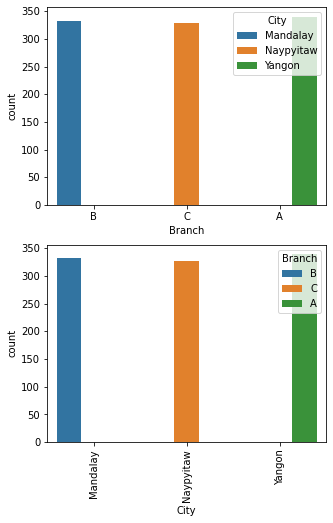

In [36]:
bivariate = bivariate_cat(cat_columns)
next(bivariate)

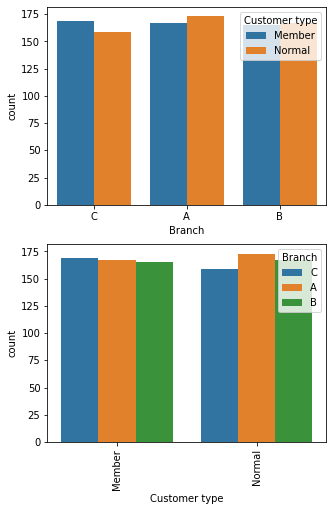

In [37]:
next(bivariate)

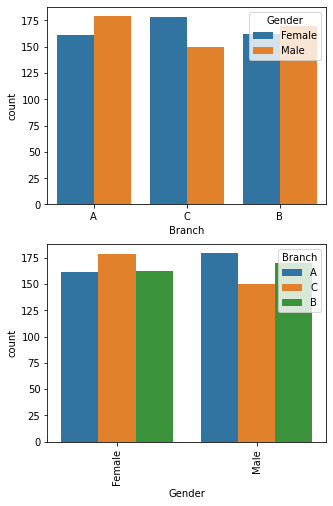

In [38]:
next(bivariate)

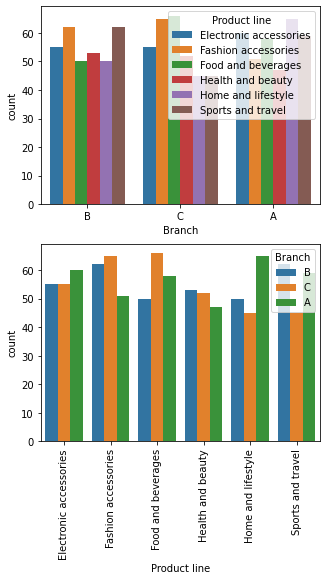

In [39]:
next(bivariate)

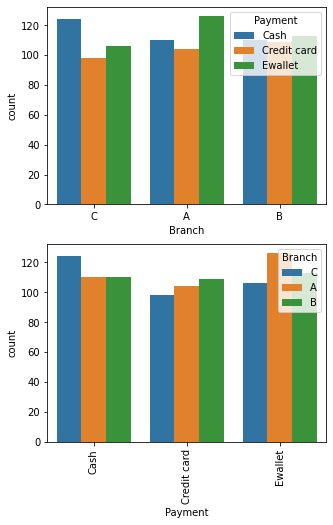

In [40]:
next(bivariate)

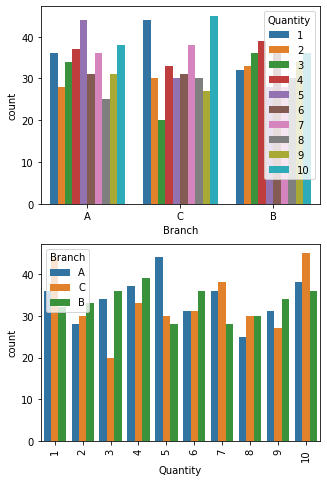

In [41]:
next(bivariate)

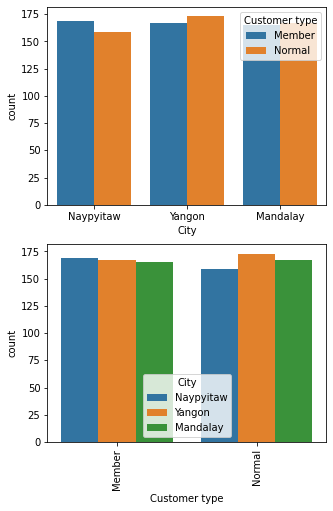

In [42]:
next(bivariate)

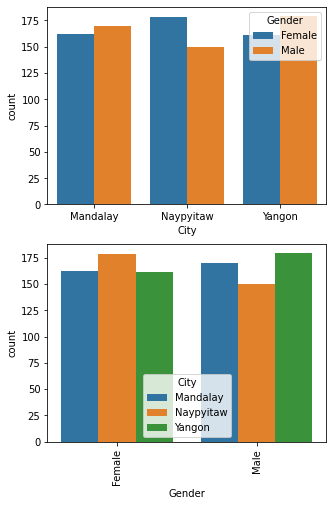

In [43]:
next(bivariate)

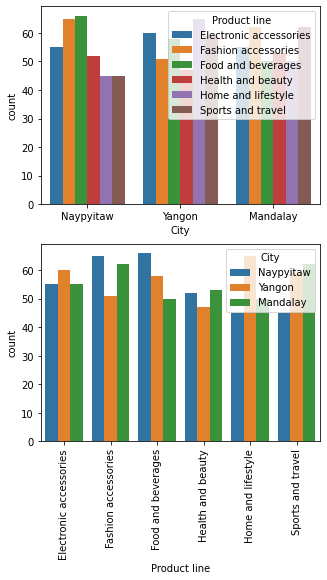

In [45]:
next(bivariate)

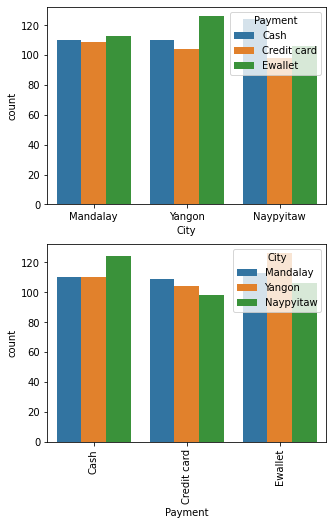

In [46]:
next(bivariate)

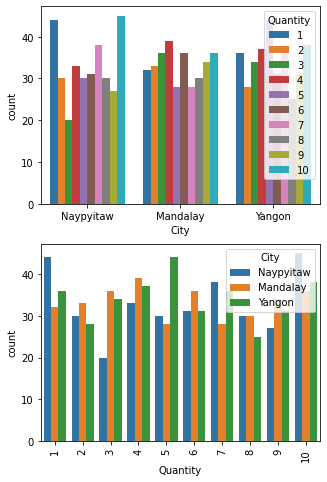

In [47]:
next(bivariate)

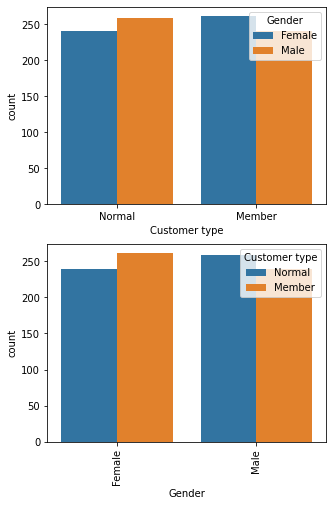

In [48]:
next(bivariate)

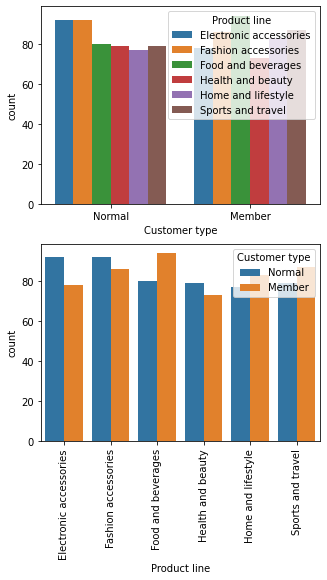

In [49]:
next(bivariate)

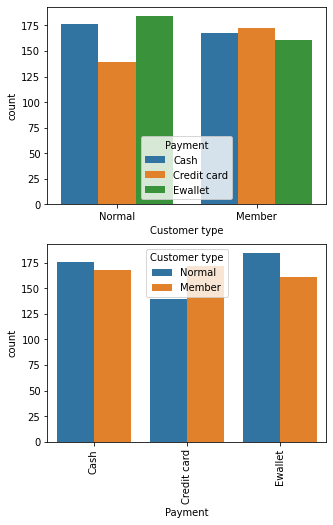

In [50]:
next(bivariate)

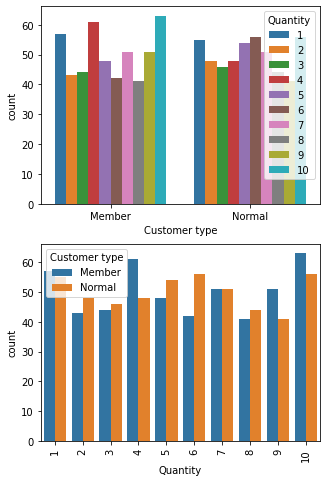

In [51]:
next(bivariate)

<AxesSubplot:xlabel='Total', ylabel='gross income'>

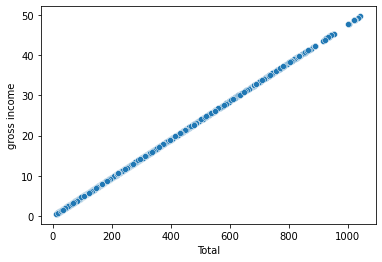

In [52]:
d = data.toPandas()
sb.scatterplot(
    data=d,
    x="Total", y="gross income",
)

 > **Positive relation betweet `Total` and `gross income`**

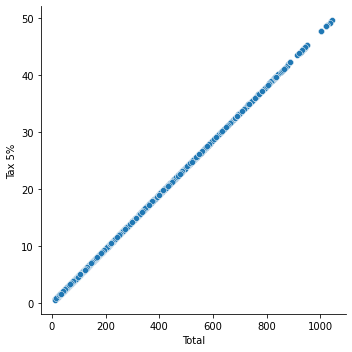

In [53]:
sb.relplot(data = d , x = 'Total' , y = 'Tax 5%')

 > **Positive relation betweet `Total` and `Tax 5%`**

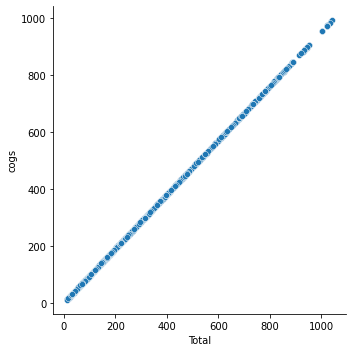

In [54]:
sb.relplot(data = d , x = 'Total' , y = 'cogs')

 > **Positive relation betweet `Total` and `cogs`**

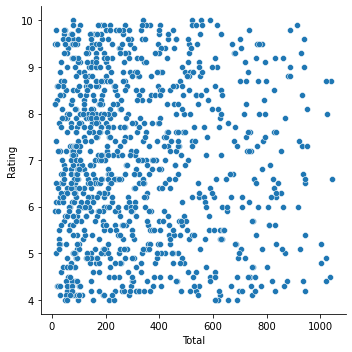

In [55]:
sb.relplot(data = d , x = 'Total' , y = 'Rating')

 > **no relation betweet `Total` and `Rating`**

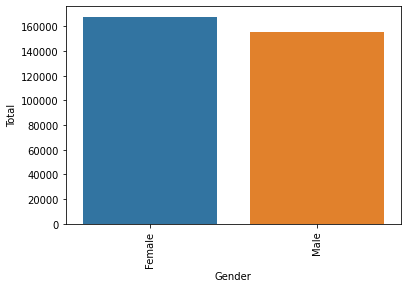

In [56]:
bivariate_cat_num('Gender' , 'Total')

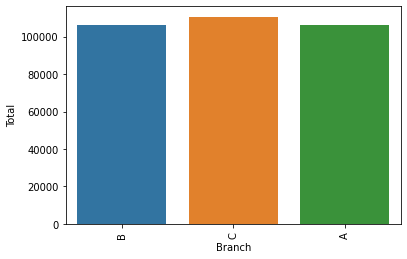

In [57]:
bivariate_cat_num('Branch' , 'Total')

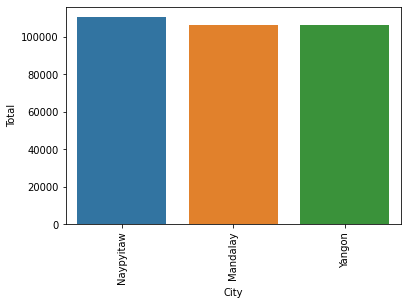

In [58]:
bivariate_cat_num('City' , 'Total')

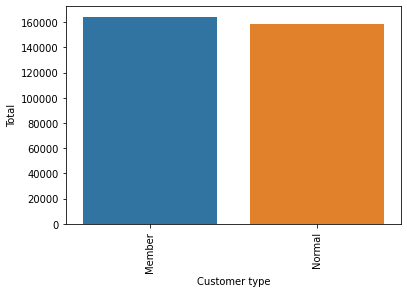

In [59]:
bivariate_cat_num('Customer type' , 'Total')

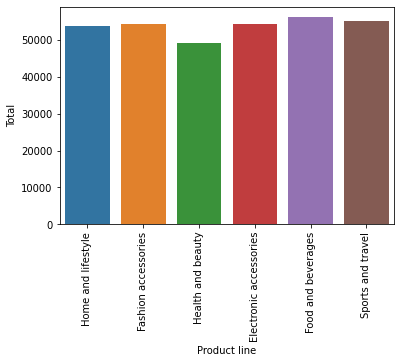

In [60]:
bivariate_cat_num('Product line' , 'Total')

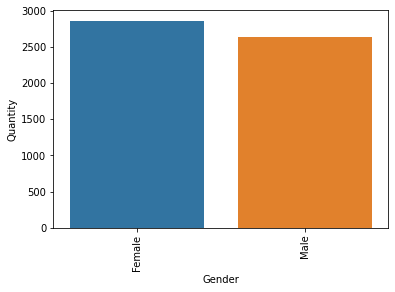

In [61]:
bivariate_cat_num('Gender' , 'Quantity')

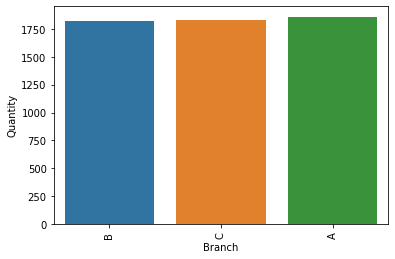

In [62]:
bivariate_cat_num('Branch' , 'Quantity')

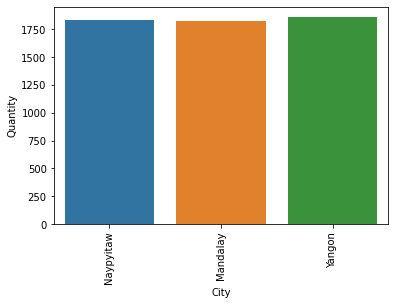

In [63]:
bivariate_cat_num('City' , 'Quantity')

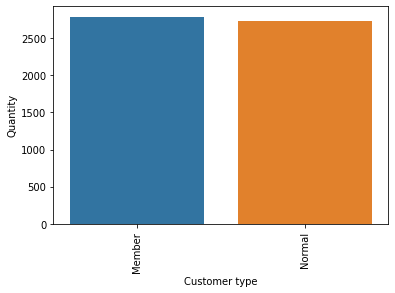

In [64]:
bivariate_cat_num('Customer type' , 'Quantity')

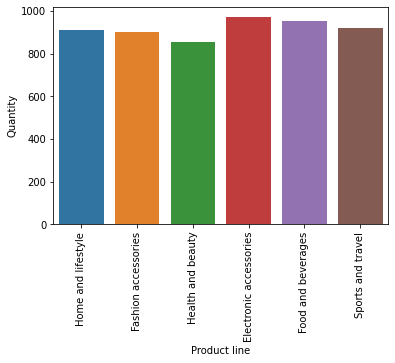

In [65]:
bivariate_cat_num('Product line' , 'Quantity')

In [66]:
num_columns

['Unit price',
 'Tax 5%',
 'Total',
 'cogs',
 'gross margin percentage',
 'gross income',
 'Rating']

In [44]:
def cat_num_summary(cat , num):
    res = data.select([cat , num]).toPandas()
    sb.boxplot(data = res , x = cat , y = num)
    plt.xticks(rotation = 90);

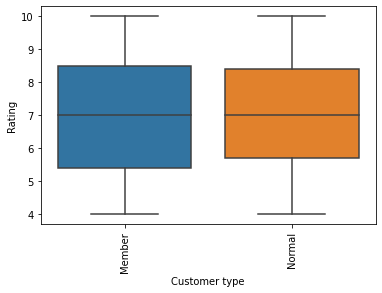

In [45]:
cat_num_summary('Customer type' , 'Rating')

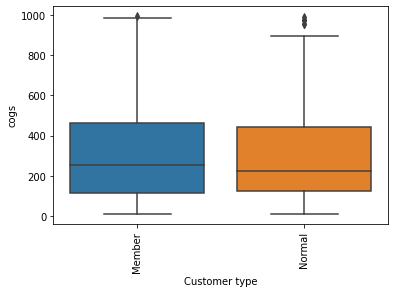

In [46]:
cat_num_summary('Customer type' , 'cogs')

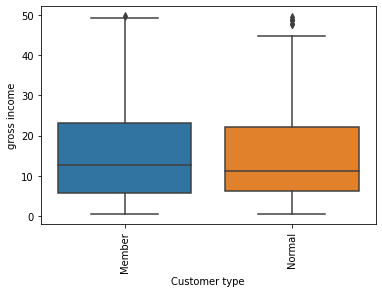

In [70]:
#gross income
cat_num_summary('Customer type' , 'gross income')

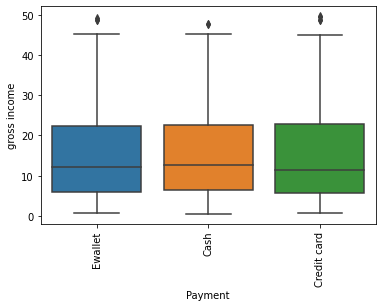

In [71]:
cat_num_summary('Payment' , 'gross income')

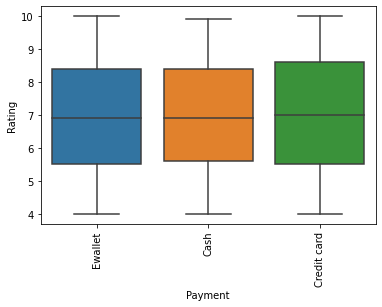

In [72]:
cat_num_summary('Payment' , 'Rating')

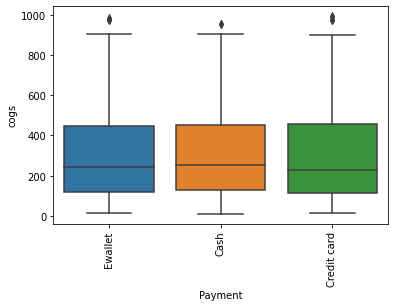

In [73]:
cat_num_summary('Payment' , 'cogs')

# Multivariate Analysis

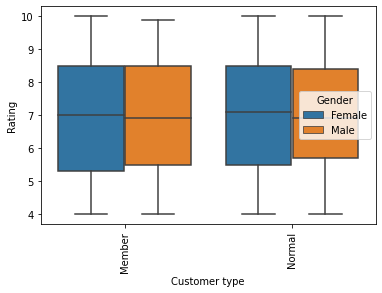

In [47]:
# make multi variate with hueristic by Gender
d = data.toPandas()
sb.boxplot(data = d , x = 'Customer type' , y = 'Rating' , hue = 'Gender')
plt.xticks(rotation = 90);

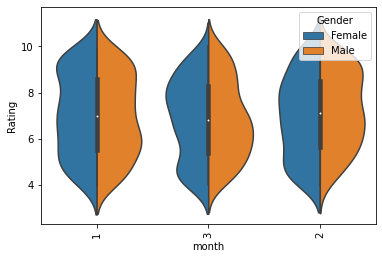

In [48]:
sb.violinplot(data = d , x = 'month' , y = 'Rating' , hue = 'Gender' , split = True)
plt.xticks(rotation = 90);

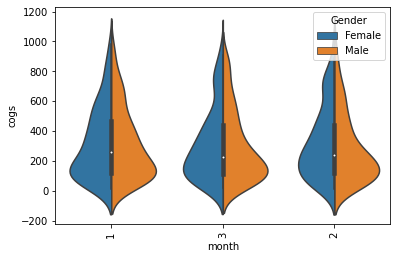

In [49]:
sb.violinplot(data = d , x = 'month' , y = 'cogs' , hue = 'Gender' , split = True)
plt.xticks(rotation = 90);

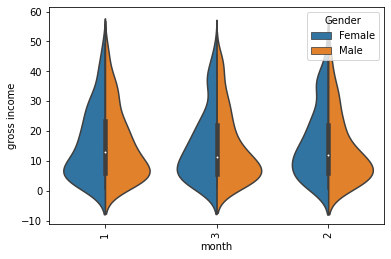

In [50]:
sb.violinplot(data = d , x = 'month' , y = 'gross income' , hue = 'Gender' , split = True)
plt.xticks(rotation = 90);

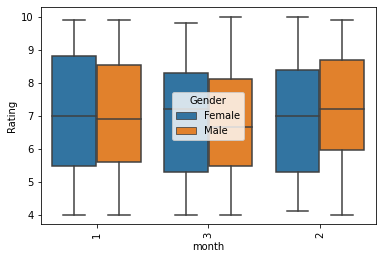

In [78]:
sb.boxplot(data = d , x = 'month' , y = 'Rating' , hue = 'Gender')
plt.xticks(rotation = 90);

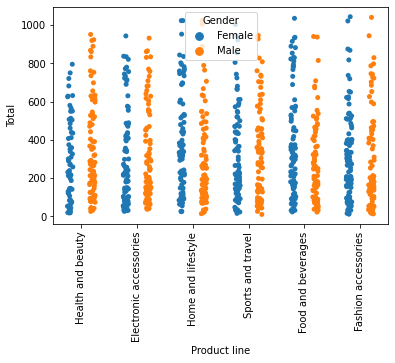

In [51]:
sb.stripplot(x='Product line', y='Total', data=d,
              jitter=True, hue='Gender', dodge=True)
plt.xticks(rotation = 90);

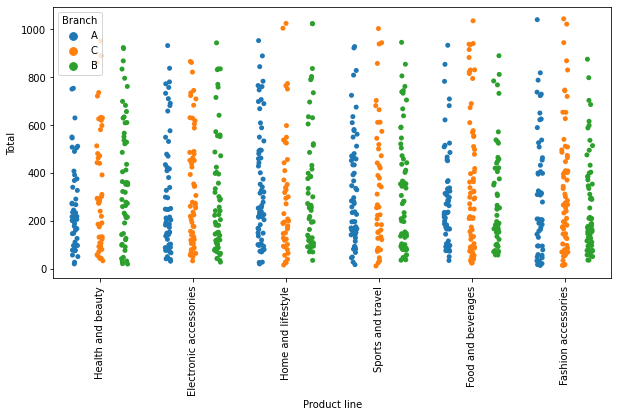

In [52]:
plt.figure(figsize = [10,5])
sb.stripplot(x='Product line', y='Total', data=d,
              jitter=True, hue='Branch', dodge=True)
plt.xticks(rotation = 90);

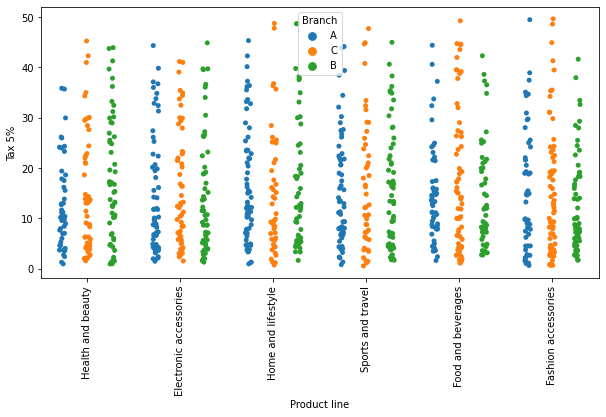

In [53]:
plt.figure(figsize = [10,5])
sb.stripplot(x='Product line', y='Tax 5%', data=d,
              jitter=True, hue='Branch', dodge=True)
plt.xticks(rotation = 90);

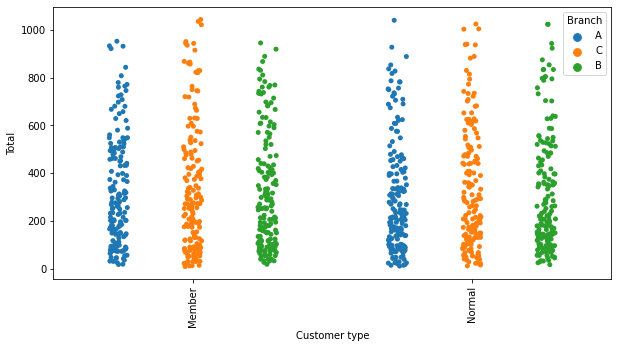

In [54]:
plt.figure(figsize = [10,5])
sb.stripplot(x='Customer type', y='Total', data=d,
              jitter=True, hue='Branch', dodge=True)
plt.xticks(rotation = 90);

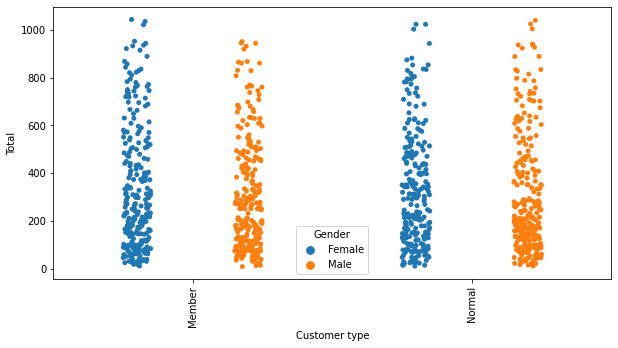

In [83]:
plt.figure(figsize = [10,5])
sb.stripplot(x='Customer type', y='Total', data=d,
              jitter=True, hue='Gender', dodge=True)
plt.xticks(rotation = 90);

<AxesSubplot:xlabel='day', ylabel='Total'>

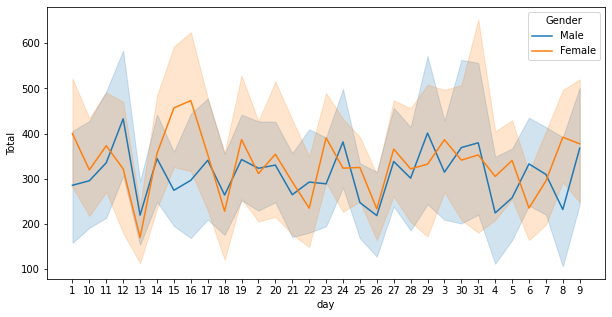

In [84]:
d['day'] = d['day'].str.replace(" " ,"")
d =  d.sort_values("day")
plt.figure(figsize = [10,5])
sb.lineplot(data = d , x = 'day' , y = 'Total' , hue = 'Gender')

> **High total of money spent by female in the half of month**

<AxesSubplot:xlabel='Quantity', ylabel='Tax 5%'>

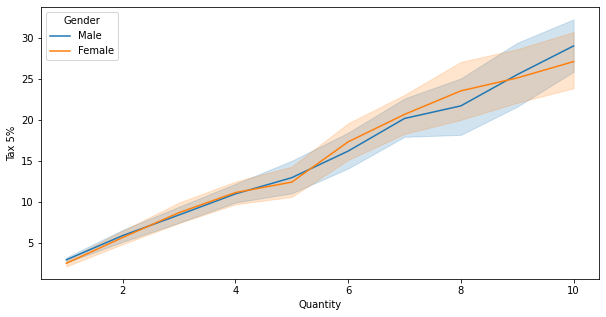

In [85]:
d = d.sort_values(by = 'Quantity')
plt.figure(figsize = [10,5])
sb.lineplot(data = d , x = 'Quantity' , y = 'Tax 5%' , hue = 'Gender')

<AxesSubplot:xlabel='Quantity', ylabel='gross income'>

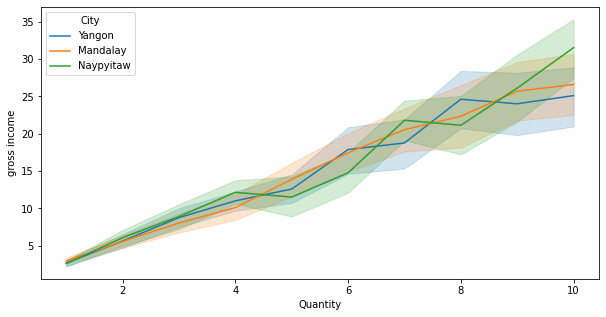

In [86]:
plt.figure(figsize = [10,5])
sb.lineplot(data = d , x = 'Quantity' , y = 'gross income' , hue = 'City')

<AxesSubplot:xlabel='Quantity', ylabel='gross income'>

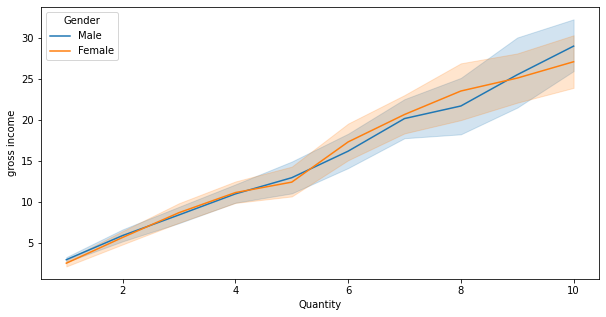

In [87]:
plt.figure(figsize = [10,5])
sb.lineplot(data = d , x = 'Quantity' , y = 'gross income' , hue = 'Gender')

<AxesSubplot:xlabel='Payment', ylabel='Tax 5%'>

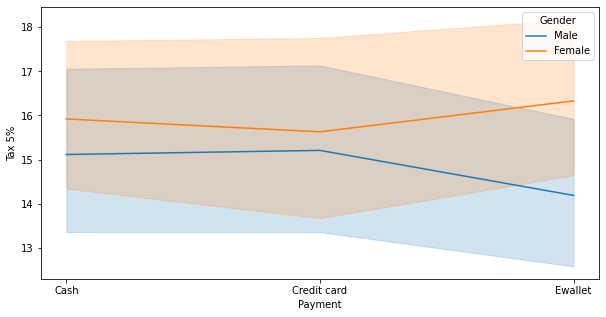

In [88]:
plt.figure(figsize = [10,5])
sb.lineplot(data = d , x = 'Payment' , y = 'Tax 5%' , hue = 'Gender')